In [1]:
import colour
from colour.plotting import *

import itertools

from sympy.ntheory import factorint

class Color():
    def __init__(self,rgb=None,xyy=None,xyz=None):
        
        if xyz:
            self.XYZ = xyz
            self.RGB = colour.XYZ_to_sRGB(xyz)
        elif xyy:
            self.XYZ = colour.xyY_to_XYZ(xyy)
            self.RGB = colour.XYZ_to_sRGB(self.XYZ)
        elif rgb:
            self.XYZ = colour.sRGB_to_XYZ(rgb)
            self.RGB = rgb
            
    def __repr__(self):
        return '({:3.0f}, {:3.0f}, {:3.0f})'.format(*[n*255 for n in self.RGB])
            

custom_colors = [
]

highs = [.6,.8,1]
lows = [0,.2,.4]

total = [0,.5,1]

for h, l in itertools.product(highs,lows):

    for i in range(2**3):
        #l = 0.1
        #h = 0.9
        r = h if ((i & 2*2) >> 2) else l
        g = h if ((i & 2) >> 1) else l
        b = h if i & 1 else l
        custom_colors.append(Color(rgb=[r,g,b]))

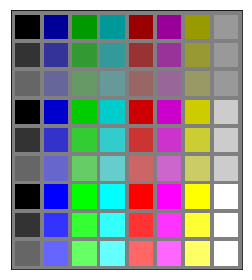

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2001275d4e0>)

In [2]:
custom_swatches = []

settings = {
        'width': 100,
        'height': 100,
        'spacing': 20,
        'columns': 8,
        'text_parameters': {
            'size': 8
        },
        'background_colour': (.5,.5,.5)
    }

for c in custom_colors:
    custom_swatches.append(ColourSwatch(RGB=c.RGB))
    
plot_multi_colour_swatches(custom_swatches, **settings)

In [3]:
import math

def ez_palette(swatches, filename=None, columns=None, background=(0,0,0), border=0, aspect=1):
    if not columns:
        columns = round(math.sqrt(len(swatches)*aspect))
        
    _figure, axes = artist()
    settings = {
        'axes': axes,
        'width': 1,
        'height': 1,
        'spacing': .3,
        'columns': columns,
        'text_parameters': {
            'size': 0
        },
        'background_colour': background,
        'standalone': True
    }
    axes.get_xaxis().set_visible(False)
    axes.get_yaxis().set_visible(False)
    spines = [i[1] for i in axes.spines.items()]
    for s in spines:
        s.set_linewidth(border)
        s.set_edgecolor(background)

    result = plot_multi_colour_swatches(swatches, **settings)
    
    if filename:
        result[0].savefig(filename, bbox_inches='tight', pad_inches=0.0)
    
    #print(len(swatches),factorint(len(swatches)))

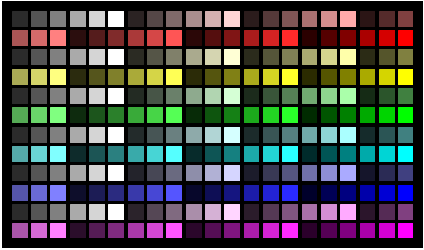

In [4]:
hsv_swatches = []

n = 6
values = [x/n for x in range(n+1)] 


for hsv in itertools.product(values, values, values):
    if hsv[2] == 0 or hsv[0] == 1:
        continue # exclude black; exclude phase rollover
    rgb = colour.HSV_to_RGB(hsv)
    ingamut = all(1 >= v >= 0 for v in rgb)
    if ingamut:
        hsv_swatches.append(ColourSwatch(RGB=rgb))

ez_palette(hsv_swatches, filename='hsv.png', columns=21, background = (0,)*3, border=10)

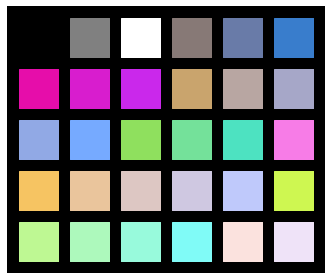

In [5]:
xyz_swatches = []

n = 5
values = [x/n for x in range(n+1)] 

for xyz in itertools.product(values, values, values):
    rgb = colour.XYZ_to_sRGB(xyz)
    ingamut = all(1 >= v >= 0 for v in rgb)
    if ingamut:
        xyz_swatches.append(ColourSwatch(RGB=rgb))
        
        
def gray_swatches(qty):
    # in rgb space
    return[ColourSwatch(RGB=[v/(qty-1)]*3) for v in range(qty)]

xyz_swatches = gray_swatches(3) + xyz_swatches[1:]

ez_palette(xyz_swatches, filename='xyz{}.png'.format(n),columns=6)



def swatches_to_csv(swatches, filename):
    outstr = 'r,g,b'
    for s in swatches:
        rgb = s.RGB
        outstr += '\n{},{},{}'.format(*rgb)
    with open(filename, 'w') as outfile:
        outfile.write(outstr)
        
swatches_to_csv(xyz_swatches, 'xyz.swatch')

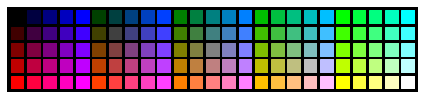

In [6]:
rgb_swatches = [ColourSwatch(RGB=(0,0,0))]

n = 4
values = [x/n for x in range(n+1)] 

for rgb in itertools.product(values, values, values):
    if all(v==0 for v in rgb):
        continue # exclude black
    rgb_swatches.append(ColourSwatch(RGB=rgb))    

ez_palette(rgb_swatches, filename='rgb.png', columns=25, background = (0,)*3)

Starting with 125 and ending with 25: 100 iterations
124  123  122  121  120  119  118  117  116  115  114  113  112  111  110  109  108  107  106  105  104  103  102  101  100  99  98  97  96  95  94  93  92  91  90  89  88  87  86  85  84  83  82  81  80  79  78  77  76  75  74  73  72  71  70  69  68  67  66  65  64  63  62  61  60  59  58  57  56  55  54  53  52  51  50  49  48  47  46  45  44  43  42  41  40  39  38  37  36  35  34  33  32  31  30  29  28  27  26  25  

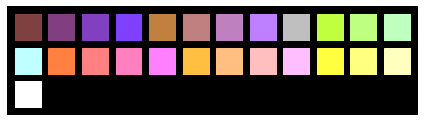

In [7]:
combo_swatches = rgb_swatches#hsv_swatches + xyz_swatches + rgb_swatches

combo_rgb = [swatch.RGB for swatch in combo_swatches]
combo_xyz = [colour.sRGB_to_XYZ(rgb) for rgb in combo_rgb]

start_qty = len(combo_xyz)
target_qty = 25

print('Starting with {} and ending with {}: {} iterations'.format(start_qty, target_qty, start_qty-target_qty))

def dist(a, b):
    #Pythagorean/Ecludian distance (in XYZ space) squared
    return sum([(an-bn)**2 for an, bn in zip(a,b)])

removed_colors = []

for i in range(start_qty - target_qty):
    # remove colors which are most similar to their neighbors
    ds = [2]*len(combo_xyz)
    for ai, bi in itertools.combinations(range(len(combo_xyz)), 2):
        #sim = 1/dist(a,b)
        #ds[ai] += sim
        #ds[bi] += sim
        sim = dist(combo_xyz[ai], combo_xyz[bi])
        ds[ai] = min(sim, ds[ai])
        ds[bi] = min(sim, ds[bi])
        
        
        
    maxi = ds.index(min(ds))
    removed_colors.append(combo_xyz.pop(maxi))
    print(len(combo_xyz), end='  ')

pruned_swatches = []
for xyz in combo_xyz:
    rgb = colour.XYZ_to_sRGB(xyz)
    rgb = [1 if v>1 else v for v in rgb] # clip in-gamut to correct for floating point errors
    pruned_swatches.append(ColourSwatch(RGB=rgb))
    
ez_palette(pruned_swatches, filename='pruned.png', columns=12)

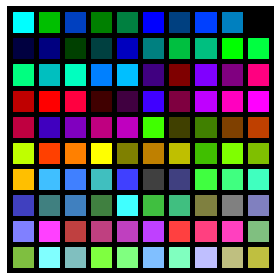

In [8]:
removed_swatches = []
for xyz in removed_colors:
    rgb = colour.XYZ_to_sRGB(xyz)
    rgb = [1 if v>1 else v if v>0 else 0 for v in rgb] # clip in-gamut to correct for floating point errors
    removed_swatches.append(ColourSwatch(RGB=rgb))
    
ez_palette(removed_swatches, filename='removed.png',)

[ 0.25203919  0.25204419  0.25203931]


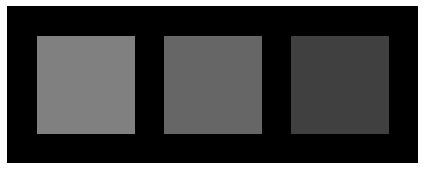

array([ 0.25203919,  0.25204419,  0.25203931])

In [9]:
import numpy as np

def average_sRGB(rgbs):
    XYZs = []
    for rgb in rgbs:
        XYZs.append(colour.sRGB_to_XYZ(rgb))
    XYZs = np.array(XYZs)
    avg_XYZ = np.average(XYZs, axis=0)
    return colour.XYZ_to_sRGB(avg_XYZ)

def invavg_sRGB(a, b):
    # returns c such that (a+c)/2 = b
    # (b is the average of a and c)
    A = colour.sRGB_to_XYZ(a)
    B = colour.sRGB_to_XYZ(b)
    C = 2*B - A
    c = colour.XYZ_to_sRGB(C)
    print(c)
    ez_palette([ColourSwatch(RGB=v) for v in [a,b,c]], columns=3)
    return c
    
invavg_sRGB([.5,.5,.5],[.4,.4,.4])

[ 0.89413715  0.65706484  0.9508583 ]


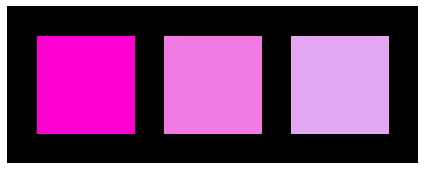

[228.0, 168.0, 242.0]


In [10]:
scalergbs = [
    [255, 0, 210],
    [242, 122, 227]
]

rgbs = []
for rgb in scalergbs:
    rgbs.append([v/255 for v in rgb])
    
try:
    print([round(v*255) for v in invavg_sRGB(*rgbs)])
except ValueError:
    print("Mix impossible!")

In [54]:
from scipy.optimize import minimize, Bounds

def clip_vector(vec):
    return [1 if v>1 else v if v>0 else 0 for v in vec]

cv = clip_vector

def vec_to_hex(vec):
    # input domain [0,1]
    outstr = ''
    for v in vec:
        outstr += hex(int(v*255))[2:].zfill(2)
        
    return outstr

def create_pair(target_rgb8, algo = 1, verbose = 0):
    if algo == -1: # do all the algos
        return [create_pair(target_rgb8, algo=i, verbose=verbose) for i in range(2)]
    
    t = [v/255 for v in target_rgb8]
    
    T = colour.sRGB_to_XYZ(t)
    
    if algo == 0:
        # scale all components uniformly. invert and reduce scaling each iteration.
        scalar = 10
        iter_scalar = -1 - 1e-2
        iters = 0 # -1 when done
        while iters != -1 and iters < 1e3:
            A = cv([v*scalar for v in T])
            a = colour.XYZ_to_sRGB(A)

            b = colour.XYZ_to_sRGB(2*T - A)

            if np.array_equal(b, cv(b)) and np.array_equal(a, cv(a)):

                ez_palette([ColourSwatch(RGB=v) for v in [a,t,b]], columns=3)

                return vec_to_hex(a), vec_to_hex(b)

            iters += 1
            scalar /= iter_scalar

        return -1
    
    if algo == 1:
        # find most extreme color using optimization techniques
        
        def loss(A):
            
            a = colour.XYZ_to_sRGB(A)
            B = 2*T - A
            b = colour.XYZ_to_sRGB(B)
            
            if np.array_equal(a, cv(a)) and np.array_equal(b, cv(b)):
                # valid colors!
                d = np.sqrt(sum([(an-bn)**2 for an, bn in zip(T, A)]))
                return -d
                
            else:
                return 100
            
        res = minimize(loss, T, method='Nelder-Mead',
                       options={'disp':verbose, 'maxfev': 3e3})
        
        A = res.x
        a = colour.XYZ_to_sRGB(A)
        b = colour.XYZ_to_sRGB(2*T - A)
        
        if np.array_equal(b, cv(b)) and np.array_equal(a, cv(a)):

                ez_palette([ColourSwatch(RGB=v) for v in [a,t,b]], columns=3)

                return vec_to_hex(a), vec_to_hex(b)
        else:
            print("Optimization failure")
            return -1
        
        
            
            
        
    
    
    

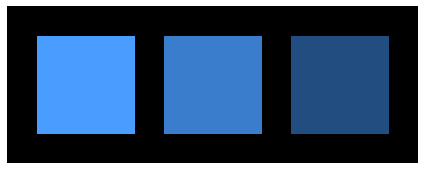

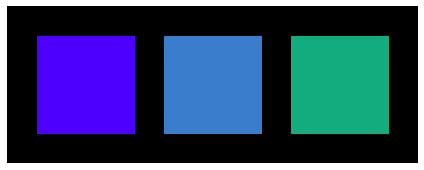

[('499cfd', '204d81'), ('4d00fe', '13ab7d')]

In [52]:
create_pair((57,125,204), algo=-1)

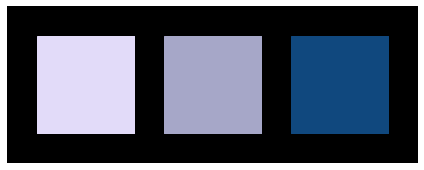

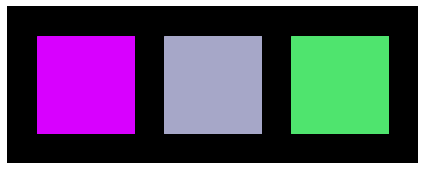

[('e1daf9', '10487d'), ('d700fe', '4fe36d')]

In [53]:
create_pair((166,167,200), algo=-1)

Optimization terminated successfully.
         Current function value: -0.209124
         Iterations: 79
         Function evaluations: 151


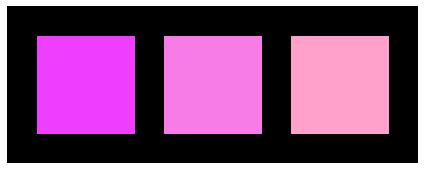

('ee3dfe', 'fea0cb')

In [32]:
create_pair((247,124,231), 1)

Optimization terminated successfully.
         Current function value: -0.218661
         Iterations: 66
         Function evaluations: 129


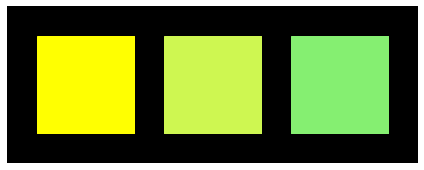

('fefe01', '84ee70')

In [33]:
create_pair((206,247,81), 1)

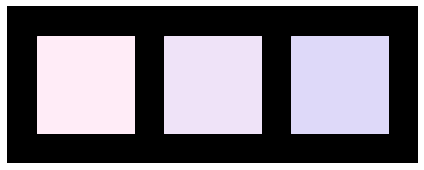

('feecf6', 'ddd9f9')

In [37]:
create_pair((239, 227, 248), 0)

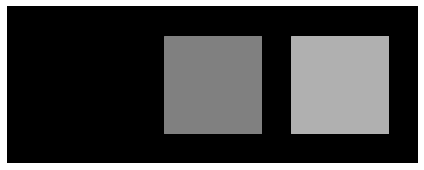

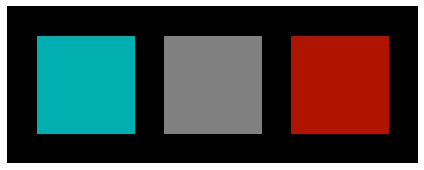

[('000000', 'afafaf'), ('01aeaf', 'af1300')]

In [55]:
create_pair((128,)*3, -1)

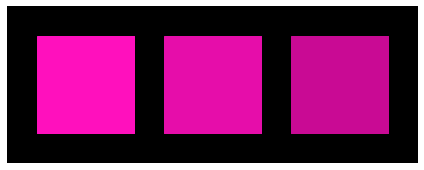

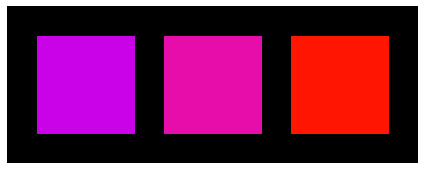

[('fe0fbc', 'c80994'), ('c902e7', 'fe1400')]

In [56]:
create_pair((230,13,170), -1)

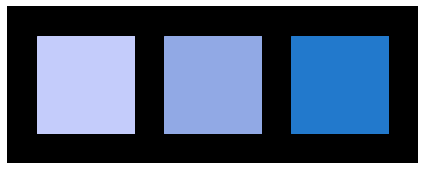

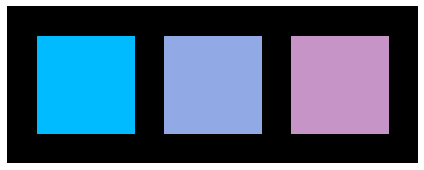

[('c3cbfb', '2279cb'), ('00bbfe', 'c693c6')]

In [57]:
create_pair((145,169,229), -1)

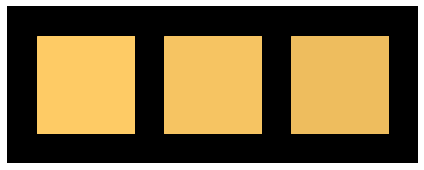

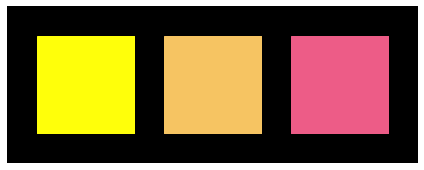

[('feca65', 'edbd5e'), ('fefe0a', 'ec5c86')]

In [58]:
create_pair((246,196,98), -1)

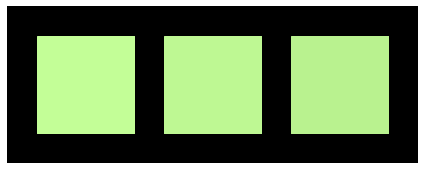

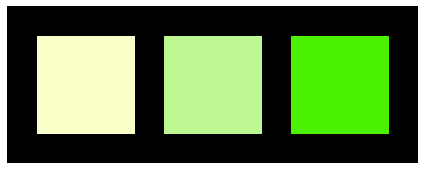

[('c2fd96', 'b9f18f'), ('fafec8', '4af000')]

In [60]:
create_pair((190,248,147), -1)